<a href="https://colab.research.google.com/github/yahya010/DocClustering/blob/Ryan_Working/Code/SeniorDesignCode_01_20_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=7e387fd8b1b9fb7b7b8957f987debf77ee43d9cabdd6a03d96b810ca6eb33934
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [25]:
import pandas as pd
import csv
import numpy as np
import matplotlib
from sentence_transformers import SentenceTransformer
import nltk
import numpy as np
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from seg_algorithm import get_optimal_splits, get_segmented_sentences
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
url = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/corpus.csv"
dataset = pd.read_csv(url)
p = 0.65 #increase p = no of segments decreases

stop_words = set(stopwords.words('english'))
transcripts = dataset.transcripts
tokenized_transcripts = pd.DataFrame(index=range(44), columns=['Sentences'])

fullTranscripts = []
filteredTranscript = []
originalTranscript_list = [] # contains 44 transcripts
transcript_list = [] #contains 44 transcripts
for transcript in transcripts[0:1]:
    transcript = sent_tokenize(transcript)
    for sentence in transcript:
      fullTranscripts.append(sentence)
# for sentence in transcripts[0:1]:
#      word_tokens = word_tokenize(sentence)
#      filtered_tokens = [w for w in word_tokens if not w.lower() in stop_words]
#      filtered_sentence = [' '.join(filtered_tokens)]
#      filteredTranscript.append(filtered_sentence)
#      print(filtered_sentence)
# filteredTranscript = sent_tokenize(filteredTranscript)
# for sentence in filteredTranscript[]:
#     transcript = sent_tokenize(transcript)
#     for sentence in transcript:
#       fullTranscripts.append(sentence)
# filteredTranscript = pd.DataFrame(filteredTranscript)
# filteredTranscript.to_csv('filteredTranscript.csv')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
# Segmentation and Embedding
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')
embeddings = model.encode(fullTranscripts)

segmentation  = get_optimal_splits(embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(fullTranscripts, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

KeyboardInterrupt: ignored

In [58]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

def filter_Sentences(unfilteredSentences, lengthFilter = -1):
  filteredSentences = unfilteredSentences

  # split sentences and check lengths
  if lengthFilter > 0:
    filteredSentences = [s for s in unfilteredSentences if len(s.split()) > lengthFilter]

    # display removed sentences
    # removedWords = [s for s in unfilteredSentences if s not in filteredSentences]

    # for w in removedWords:
    #    print(w)

In [15]:
# PrePCA Cosine Similarity Matrix
heatmap = np.zeros(shape=(len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    sent = embeddings[i]
    for j in range(len(embeddings)):
        sent2 = embeddings[j]
        cosSim = cos_similarity(sent, sent2)
        heatmap[i,j] = cosSim

In [16]:
# PCA-95 Dimensionality Reduction
embedding = embeddings
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform(embedding)
print(reduced_embedding.shape)

(786, 225)


In [17]:
# PostPCA Cosine Similarity Matrix (Sentence Similarity Matrix)
heatmapPost = np.zeros(shape=(len(reduced_embedding), len(reduced_embedding)))
for i in range(len(reduced_embedding)):
    sentPost = reduced_embedding[i]
    for j in range(len(reduced_embedding)):
        sent2Post = reduced_embedding[j]
        cosSimPost = cos_similarity(sentPost, sent2Post)
        heatmapPost[i,j] = cosSimPost

In [ ]:
# Remove Diagonal
# heatmapRD = np.delete(heatmap,range(0,heatmap.shape[0]**2,(heatmap.shape[0]+1))).reshape(heatmap.shape[0],(heatmap.shape[1]-1))

In [18]:
# Standardize the Data
print(heatmap)

[[1.    0.382 0.445 ... 0.302 0.474 0.528]
 [0.382 1.    0.519 ... 0.394 0.371 0.502]
 [0.445 0.519 1.    ... 0.344 0.439 0.485]
 ...
 [0.302 0.394 0.344 ... 1.    0.225 0.347]
 [0.474 0.371 0.439 ... 0.225 1.    0.554]
 [0.528 0.502 0.485 ... 0.347 0.554 1.   ]]


In [19]:
ind = np.argpartition(heatmap[0,:], -10)[-10:]
top4 = heatmap[0,ind]
print(ind)
print(top4)

[401 243 253  83 451 179 706 170 325   0]
[0.531 0.549 0.553 0.555 0.554 0.561 0.578 0.583 0.602 1.   ]


In [20]:
top5 = np.zeros(shape=(y, x))
ind = np.argpartition(heatmap[0,:], -5)[-5:]
top4 = heatmap[0,ind]
print(ind)
print(top4)
top4 = pd.DataFrame(top4)
top4.to_csv('top4.csv')
for i in range 

SyntaxError: ignored

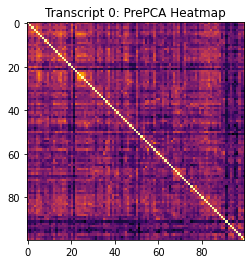

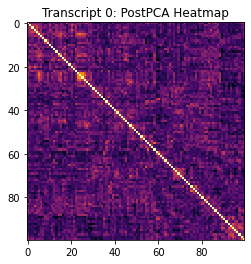

In [21]:
# Prenormalized Heatmaps

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCA[i,j] = heatmap[i,j]
data = heatmapPrePCA
plt.imshow( data , cmap = 'inferno' , interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCA[i,j] = heatmapPost[i,j]
data = heatmapPostPCA
plt.imshow( data , cmap = 'inferno' , interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [22]:
# # Standardized

# # Normalize Pre and Post Cosine Similarity Matrixs
# heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
# heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
# heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
# heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)

# Zpositive = np.ma.masked_less(heatmapPreNorm, .3)
# Znegative = np.ma.masked_greater(heatmapPreNorm, .3)
# # PrePCA Heatmap
# x = 100
# y = 100
# heatmapPrePCAStand = np.zeros(shape=(y, x))
# for i in range(y):
#   for j in range(x):
#     heatmapPrePCAStand[i,j] = heatmapPreNorm[i,j]
# data = Zpositive
# plt.imshow( data , cmap = 'inferno', interpolation = 'nearest' )
# # color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
# plt.show()
# x = 100
# y = 100
# heatmapPrePCAStand = np.zeros(shape=(y, x))
# for i in range(y):
#   for j in range(x):
#     heatmapPrePCAStand[i,j] = heatmapPreNorm[i,j]
# data = Znegative
# plt.imshow( data , cmap = 'Blues', interpolation = 'nearest' )
# # color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
# plt.show()

# # PostPCA Heatmap
# x = 100
# y = 100
# heatmapPostPCAStand = np.zeros(shape=(y, x))
# for i in range(y):
#   for j in range(x):
#     heatmapPostPCAStand[i,j] = heatmapPostNorm[i,j]
# data = heatmapPostPCAStand
# plt.imshow( data , cmap = 'inferno' , vmin = -0.6, vmax = 0.8, interpolation = 'nearest' )
# # color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
# plt.show()

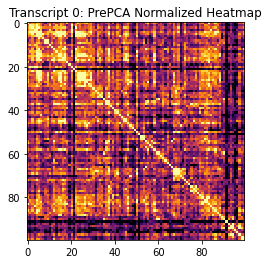

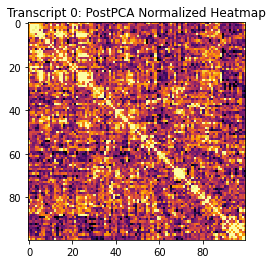

In [23]:
# Normalized Heatmaps

# Normalize Pre and Post Cosine Similarity Matrixs
heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)
# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCANorm[i,j] = heatmapPreNorm[i,j]
data = heatmapPrePCANorm
plt.imshow( data , cmap = 'inferno' , vmin = 0.2, vmax = 0.6, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCANorm[i,j] = heatmapPostNorm[i,j]
data = heatmapPostPCANorm
plt.imshow( data , cmap = 'inferno' , vmin = 0.1, vmax = 0.46, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
plt.show()


In [24]:
heatmapdf = pd.DataFrame(data=heatmap)
heatmapdf.to_csv('heatmap.csv')
heatmapPostdf = pd.DataFrame(data=heatmapPost)
heatmapPostdf.to_csv('reduced_heatmap_0.csv')
heatmapPrePCANormdf = pd.DataFrame(data=heatmapPreNorm)
heatmapPrePCANormdf.to_csv('heatmapPreNorm.csv')
heatmapPostPCANormdf = pd.DataFrame(data=heatmapPostNorm)
heatmapPostPCANormdf.to_csv('heatmapPostNorm.csv')

In [ ]:
# Test Code
# transcript_list = [] # contains 44 transcripts
# for transcript in transcripts[0:3]:    
#   transcript_list.append(sent_tokenize(transcript))

In [ ]:
# Test Code

# fullTranscripts = pd.DataFrame(fullTranscripts)
# fullTranscripts.to_csv('fullTranscripts.csv')

# embedding = pd.DataFrame(embedding)
# embedding.to_csv('embedding.csv')

# reduced_embedding = pd.DataFrame(reduced_embedding)
# reduced_embedding.to_csv('reduced_embedding.csv')

In [59]:
filteredSentences = filter_Sentences(fullTranscripts, 6)